<a href="https://colab.research.google.com/github/TejkumarGudi/FINAL-YEAR-PROJECT/blob/main/Project_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#  Import libraries and mount Google Drive

# from google.colab import drive
# drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# **Move kaggle.json to the correct folder**  
This cell puts your API key in the correct directory for Kaggle to work.


In [2]:
#  Setup Kaggle API credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


#**Download Amazon Reviews dataset directly from Kaggle**  
This cell downloads the dataset using the Kaggle API.  
Dataset: bittlingmayer/amazonreviews


In [3]:
#  Download dataset from Kaggle
!kaggle datasets download -d bittlingmayer/amazonreviews


Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


# **Unzip the downloaded dataset**  
This extracts the dataset into your Colab environment.


In [ ]:
#  Unzip downloaded file
!unzip amazonreviews.zip


Archive:  amazonreviews.zip
replace test.ft.txt.bz2? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train.ft.txt.bz2? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


# **Extract train & test .bz2 files**  
This cell extracts the compressed FastText files so we can preprocess and load them.


In [ ]:
# Extract .bz2 files
import bz2

def decompress_bz2(input_path, output_path):
    with bz2.BZ2File(input_path, 'rb') as f_in:
        data = f_in.read()
        with open(output_path, 'wb') as f_out:
            f_out.write(data)

decompress_bz2("train.ft.txt.bz2", "train.ft.txt")
decompress_bz2("test.ft.txt.bz2", "test.ft.txt")


# **Load FastText Amazon Reviews dataset**  
This cell loads the extracted `.txt` files and converts them into a structured DataFrame  
with 2 columns: **label** and **review**.


In [ ]:
import pandas as pd
# Load FastText dataset
def load_fasttext(path):
    texts = []
    labels = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split(" ", 1)
            if len(parts) == 2:
                label = parts[0].replace("__label__", "")
                text = parts[1]
                labels.append(label)
                texts.append(text)
    return pd.DataFrame({"label": labels, "review": texts})

train_df = load_fasttext("train.ft.txt")
test_df = load_fasttext("test.ft.txt")

train_df.head()


,label,review
0,2,Stuning even for the non-gamer: This sound tra...
1,2,The best soundtrack ever to anything.: I'm rea...
2,2,Amazing!: This soundtrack is my favorite music...
3,2,Excellent Soundtrack: I truly like this soundt...
4,2,"Remember, Pull Your Jaw Off The Floor After He..."


# **Explore Dataset Structure**  
This cell shows dataset shape, distribution of labels, and sample text.


In [ ]:
# Dataset exploration
print("Train Shape:", train_df.shape)
print("Test Shape:", test_df.shape)

train_df['label'].value_counts()
test_df['label'].value_counts()

Train Shape: (3600000, 2)
Test Shape: (400000, 2)


,count
label,
2,200000
1,200000


# **Preprocess Text Data**  
This cell cleans the review text by removing special characters,  
converting to lowercase, removing stopwords, and applying stemming.


In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Apply cleaning
train_df["clean_review"] = train_df["review"].apply(clean_text)
test_df["clean_review"] = test_df["review"].apply(clean_text)

train_df.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,label,review,clean_review
0,2,Stuning even for the non-gamer: This sound tra...,stune even nongam sound track beauti paint sen...
1,2,The best soundtrack ever to anything.: I'm rea...,best soundtrack ever anyth im read lot review ...
2,2,Amazing!: This soundtrack is my favorite music...,amaz soundtrack favorit music time hand intens...
3,2,Excellent Soundtrack: I truly like this soundt...,excel soundtrack truli like soundtrack enjoy v...
4,2,"Remember, Pull Your Jaw Off The Floor After He...",rememb pull jaw floor hear youv play game know...


# **Check for missing values and duplicates**

Data quality is important before modeling.  
In this cell, we:
- Check if there are any missing (NaN) values  
- Count duplicate review texts in the training dataset


In [ ]:
# Missing values
print("Missing values per column:\n", train_df.isnull().sum())

# Duplicate reviews
num_duplicates = train_df.duplicated(subset=["review"]).sum()
print("\nNumber of duplicate reviews in train_df:", num_duplicates)

# Optionally: remove duplicate reviews
train_df = train_df.drop_duplicates(subset=["review"]).reset_index(drop=True)
print("Shape after dropping duplicates:", train_df.shape)


Missing values per column:
 label           0
review          0
clean_review    0
dtype: int64

Number of duplicate reviews in train_df: 0
Shape after dropping duplicates: (3600000, 3)


# **EDA**

## **Sentiment label distribution**

We need to understand whether the dataset is balanced or imbalanced.

In this cell, we:
- Count how many `positive` and `negative` reviews are in the training set  
- Visualize the distribution using a bar chart


label
2    1800000
1    1800000
Name: count, dtype: int64


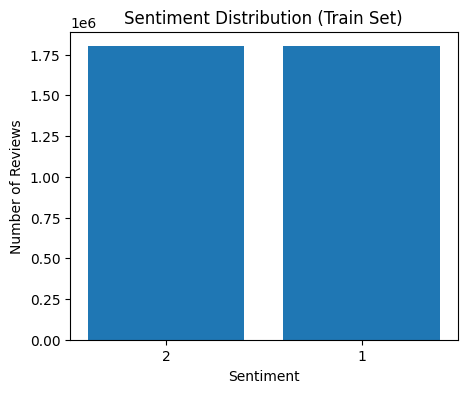

In [ ]:
label_counts = train_df["label"].value_counts()
print(label_counts)

plt.figure(figsize=(5,4))
plt.bar(label_counts.index, label_counts.values)
plt.title("Sentiment Distribution (Train Set)")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()


## **Review length analysis (number of words)**

Longer reviews may contain richer information, while very short reviews may be noisy.

In this cell, we:
- Compute the length of each review in words  
- Plot the distribution of review lengths  
- Compare average length between positive and negative reviews


Review length statistics (in words):
count    3.600000e+06
mean     7.848273e+01
std      4.283280e+01
min      2.000000e+00
25%      4.200000e+01
50%      7.000000e+01
75%      1.080000e+02
max      2.570000e+02
Name: review_len_words, dtype: float64


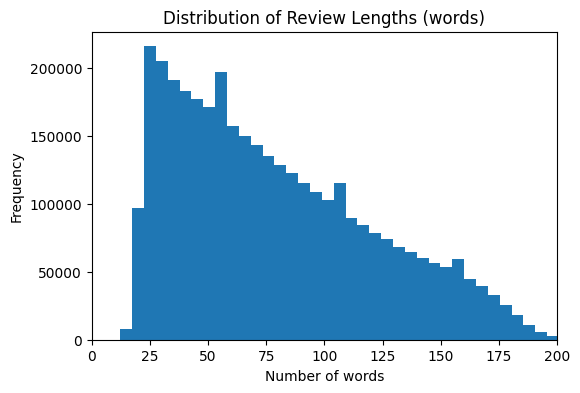


Average review length by sentiment:
label
1    81.502666
2    75.462801
Name: review_len_words, dtype: float64


In [ ]:
# Add a column with word counts
train_df["review_len_words"] = train_df["review"].apply(lambda x: len(str(x).split()))

print("Review length statistics (in words):")
print(train_df["review_len_words"].describe())

# Histogram of review lengths (truncated for readability)
plt.figure(figsize=(6,4))
plt.hist(train_df["review_len_words"], bins=50)
plt.xlim(0, 200)  # limit x-axis to focus on majority
plt.title("Distribution of Review Lengths (words)")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()

# Average length per sentiment
print("\nAverage review length by sentiment:")
print(train_df.groupby("label")["review_len_words"].mean())


## **Sample reviews for each sentiment**

To get an intuitive feel for the data, we inspect a few random examples:
- 3 positive reviews  
- 3 negative reviews


In [ ]:
print("=== Sample POSITIVE reviews (label=2) ===")
for i, row in train_df[train_df["label"] == "2"].sample(3, random_state=42).iterrows():
    print("\nReview:", row["review"])

print("\n\n=== Sample NEGATIVE reviews (label=1) ===")
for i, row in train_df[train_df["label"] == "1"].sample(3, random_state=42).iterrows():
    print("\nReview:", row["review"])


=== Sample POSITIVE reviews (label=2) ===

Review: Perfect Mantra: I've been looking for this mantra for a long time. My children at yoga and me are very glad that this lotus mantra is making our class more enjoyable. Recommended even for adults with the motion of lotusflower opening and going back into the ground.

Review: Quality: I'm just a little disapointed with the quality of the Metal Case, cause the only thing I saw was the photo on the web

Review: Exceptional murder-mystery writer scores big.: Being a purveyor of exceptional mystery and crime novels, what a pleasant surprise to find one of my random picks turning out so well. Parker has an uncanny grasp of the lifestyle in orange county and a keen insight into the personalities of its inhabitants. Naughton is a true crime noir treat, and Parker's personalization of him evokes the same dread as the main character feels.Highly recommended.


=== Sample NEGATIVE reviews (label=1) ===

Review: The History of Torture and Execution

##  **WordCloud for Positive and Negative Reviews**  
This cell generates two separate WordClouds:
- One for **positive** reviews (label = 2)  
- One for **negative** reviews (label = 1)

The WordCloud visualizes the most frequent important words in each group.


In [ ]:

from wordcloud import WordCloud
import matplotlib.pyplot as plt


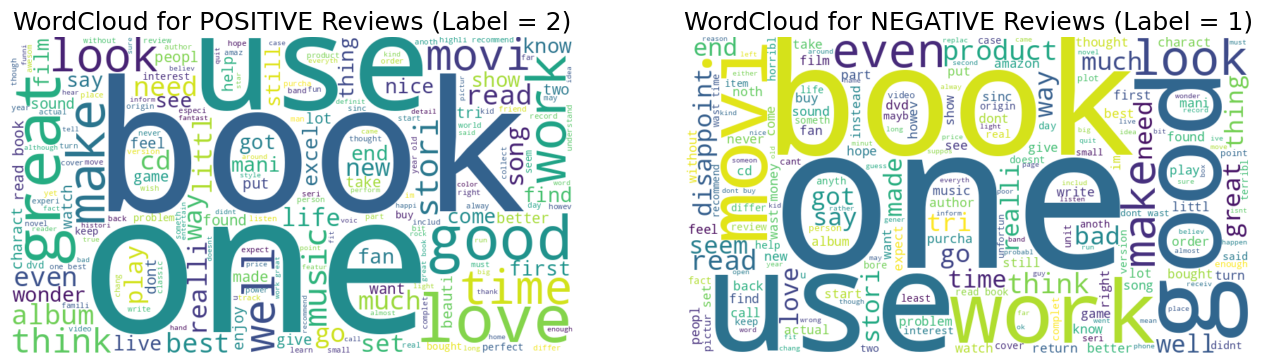

In [ ]:

import random # Used for random sampling, ensure it's available or use .sample()

# --- OPTION 1: SAMPLING TO REDUCE RAM CONSUMPTION ---

# Define the maximum number of reviews to sample for the WordCloud creation.
# Adjust this number based on the size of your full dataframe and available RAM.
SAMPLE_SIZE = 50000
# Note: If your dataframe is smaller than 50k, the code will use all available reviews.

# Generate text groups based on correct labels, using a sample
# The .sample() function selects a random subset of reviews, limited by SAMPLE_SIZE.

# Get the positive reviews and sample them
positive_df = train_df[train_df["label"] == "2"]
positive_reviews = " ".join(positive_df["clean_review"].sample(
    n=min(len(positive_df), SAMPLE_SIZE),
    random_state=42 # Set random_state for reproducibility
))

# Get the negative reviews and sample them
negative_df = train_df[train_df["label"] == "1"]
negative_reviews = " ".join(negative_df["clean_review"].sample(
    n=min(len(negative_df), SAMPLE_SIZE),
    random_state=42
))


# Create WordCloud objects
wc_positive = WordCloud(width=800, height=450, background_color="white").generate(positive_reviews)
wc_negative = WordCloud(width=800, height=450, background_color="white").generate(negative_reviews)

# Plot side-by-side WordClouds
plt.figure(figsize=(16,8))

# Positive WordCloud
plt.subplot(1,2,1)
plt.imshow(wc_positive, interpolation="bilinear")
plt.title("WordCloud for POSITIVE Reviews (Label = 2)", fontsize=18)
plt.axis("off")

# Negative WordCloud
plt.subplot(1,2,2)
plt.imshow(wc_negative, interpolation="bilinear")
plt.title("WordCloud for NEGATIVE Reviews (Label = 1)", fontsize=18)
plt.axis("off")

plt.show()

##  **TF-IDF**  
TF-IDF stands for Term Frequency-Inverse Document Frequency. It's a numerical statistic used in natural language processing (NLP) and information retrieval to reflect how important a word is to a document in a collection or corpus.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X_train = train_df["clean_review"]
y_train = train_df["label"]
X_test = test_df["clean_review"]
y_test = test_df["label"] # Assuming 'label' column exists in test_df for evaluation

# 1. Initialize the TfidfVectorizer
# We limit the features to the top 5000 words based on document frequency
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# 2. Fit the vectorizer on the training data and transform it
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# 3. Transform the test data using the *fitted* vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("Shape of TF-IDF matrix (Train):", X_train_tfidf.shape)
print("Shape of TF-IDF matrix (Test):", X_test_tfidf.shape)

Shape of TF-IDF matrix (Train): (3600000, 5000)
Shape of TF-IDF matrix (Test): (400000, 5000)


##  **Model Training**
Three models are selected in this study for training.
1. MultinomialNB (Naive Bayes)
2. Logistic Regression
3. LinearSVC (Support Vector Classification)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import pandas as pd



### 1. Model Training and Prediction ###

# Initialize models
mnb_model = MultinomialNB()
lr_model = LogisticRegression(solver='liblinear', random_state=42)
lsvc_model = LinearSVC(random_state=42, dual='auto') # Note: dual='auto' is recommended

# Train models
print("--- Training Models ---")
mnb_model.fit(X_train_tfidf, y_train)
lr_model.fit(X_train_tfidf, y_train)
lsvc_model.fit(X_train_tfidf, y_train)

# Make predictions (class labels)
y_pred_mnb = mnb_model.predict(X_test_tfidf)
y_pred_lr = lr_model.predict(X_test_tfidf)
y_pred_lsvc = lsvc_model.predict(X_test_tfidf)

# Get probabilities (needed for ROC/AUC, LinearSVC does not provide this easily)
y_proba_mnb = mnb_model.predict_proba(X_test_tfidf)[:, 1]
y_proba_lr = lr_model.predict_proba(X_test_tfidf)[:, 1]

# Store results
models = {
    "MultinomialNB": y_pred_mnb,
    "Logistic Regression": y_pred_lr,
    "LinearSVC": y_pred_lsvc
}

print("\n--- Model Accuracy Scores ---")
for name, y_pred in models.items():
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")

--- Training Models ---

--- Model Accuracy Scores ---
MultinomialNB Accuracy: 0.8348
Logistic Regression Accuracy: 0.8857
LinearSVC Accuracy: 0.8855


# **Classification report**

In [ ]:
for name, y_pred in models.items():
    print(f"\n--- Classification Report ({name}) ---")
    print(classification_report(y_test, y_pred))


--- Classification Report (MultinomialNB) ---
              precision    recall  f1-score   support

           1       0.83      0.84      0.84    200000
           2       0.84      0.83      0.83    200000

    accuracy                           0.83    400000
   macro avg       0.83      0.83      0.83    400000
weighted avg       0.83      0.83      0.83    400000


--- Classification Report (Logistic Regression) ---
              precision    recall  f1-score   support

           1       0.89      0.88      0.89    200000
           2       0.88      0.89      0.89    200000

    accuracy                           0.89    400000
   macro avg       0.89      0.89      0.89    400000
weighted avg       0.89      0.89      0.89    400000


--- Classification Report (LinearSVC) ---
              precision    recall  f1-score   support

           1       0.89      0.88      0.89    200000
           2       0.88      0.89      0.89    200000

    accuracy                           

# **Confusion Matrix**

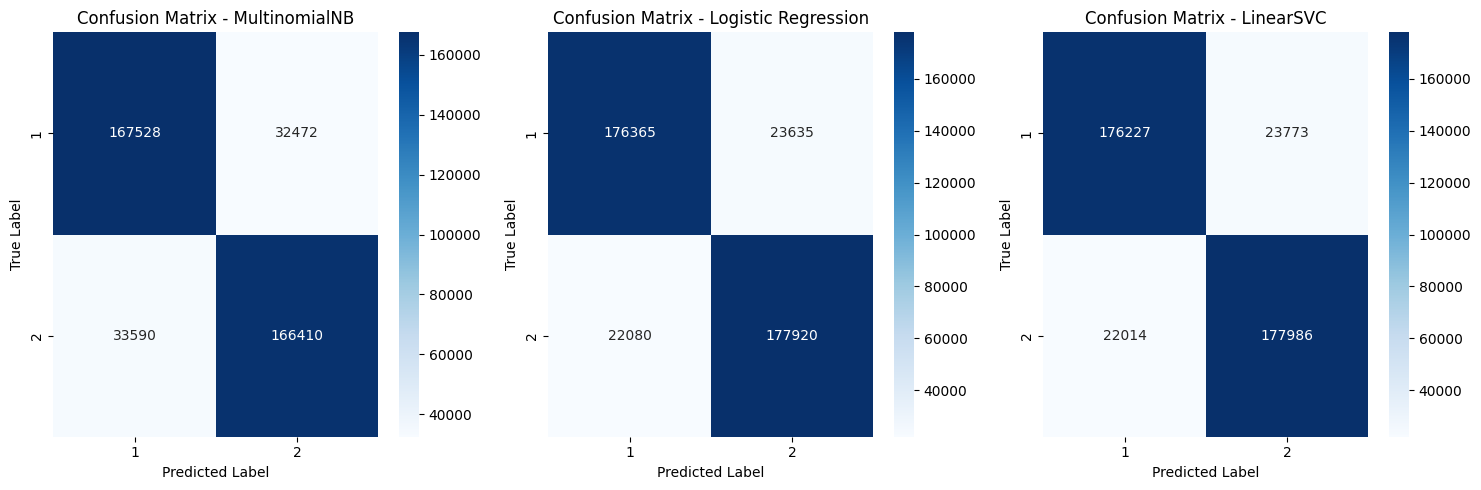

In [ ]:
plt.figure(figsize=(15, 5))
class_labels = sorted(y_test.unique()) # Assumes your labels are 0 and 1, or text labels

for i, (name, y_pred) in enumerate(models.items()):
    cm = confusion_matrix(y_test, y_pred)

    plt.subplot(1, 3, i + 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

plt.tight_layout()
plt.show()

# **ROC Curve**

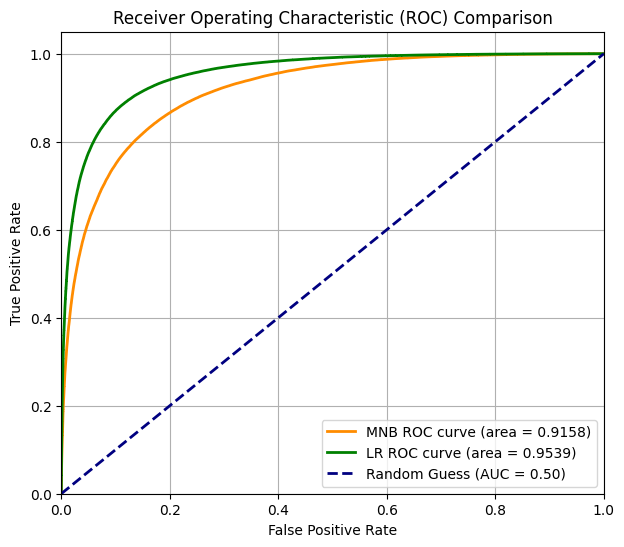

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# 1. Initialize LabelEncoder
# This will convert string labels (e.g., '1', '2') into integers (0, 1)
le = LabelEncoder()

# 2. Fit the encoder and transform the true labels (y_test)
# This creates the necessary binary format (0 or 1) for roc_curve
# Ensure y_test and y_train are consistent if you use this elsewhere
y_test_encoded = le.fit_transform(y_test)

# --- ROC Curve Calculation (Updated) ---
plt.figure(figsize=(7, 6))

# 1. Multinomial Naive Bayes
# Use the encoded y_test
fpr_mnb, tpr_mnb, _ = roc_curve(y_test_encoded, y_proba_mnb)
roc_auc_mnb = auc(fpr_mnb, tpr_mnb)
plt.plot(fpr_mnb, tpr_mnb, color='darkorange', lw=2,
         label=f'MNB ROC curve (area = {roc_auc_mnb:.4f})')

# 2. Logistic Regression
# Use the encoded y_test
fpr_lr, tpr_lr, _ = roc_curve(y_test_encoded, y_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, color='green', lw=2,
         label=f'LR ROC curve (area = {roc_auc_lr:.4f})')

# 3. Random baseline
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess (AUC = 0.50)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()